# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The two most common gaits are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot moves one leg at a time, while the ripple gait is a more complex gait where the legs move in a wave-like motion.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)



## Tripod gait, one leg at a time

The tripod gait is a simple gait where the robot moves one leg at a time. The robot moves one leg forward, then the other leg forward, then the third leg forward. This is repeated until the robot has moved all three legs forward.

Parametrization of the tripod gait is done by specifying the following parameters:

  1. Leg swing angle
  2. Leg stance angle
  3. Leg lift angle
  4. Leg lift time
  5. Leg swing time
  6. Leg stance time

As before, we are going to start with simple 2D plots to build intuition via simple visualizations.

In [9]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x78e0a0b19d60>>
Traceback (most recent call last):
  File "/media/anton/dev/ros_workspaces/drqp_ws/src/Dr.QP/.venv/lib/python3.12/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/media/anton/dev/ros_workspaces/drqp_ws/src/Dr.QP/.venv/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/media/anton/dev/ros_workspaces/drqp_ws/src/Dr.QP/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1454, in _step
    self._init_draw()
  File "/media/anton/dev/ros_workspaces/drqp_ws/src/Dr.QP/.venv/lib/python3.12/site-packages/matplotlib/animation.py", line 1770, in _init_draw
    self._draw_frame(frame_data)
  File "/media/anton/dev/ros_workspaces/drqp_ws/src/Dr.QP/.venv/lib

Offsets at phase 0.0: {'left_front': Point3D(-25.0000, 0.0000, 0.0000, None), 'right_middle': Point3D(-25.0000, 0.0000, 0.0000, None), 'left_back': Point3D(-25.0000, 0.0000, 0.0000, None), 'right_front': Point3D(25.0000, 0.0000, 0.0000, None), 'left_middle': Point3D(25.0000, 0.0000, 0.0000, None), 'right_back': Point3D(25.0000, 0.0000, 0.0000, None)}
Offsets at phase 0.25: {'left_front': Point3D(-0.0000, 0.0000, 40.0000, None), 'right_middle': Point3D(-0.0000, 0.0000, 40.0000, None), 'left_back': Point3D(-0.0000, 0.0000, 40.0000, None), 'right_front': Point3D(0.0000, 0.0000, 0.0000, None), 'left_middle': Point3D(0.0000, 0.0000, 0.0000, None), 'right_back': Point3D(0.0000, 0.0000, 0.0000, None)}
Offsets at phase 0.5: {'left_front': Point3D(25.0000, 0.0000, 0.0000, None), 'right_middle': Point3D(25.0000, 0.0000, 0.0000, None), 'left_back': Point3D(25.0000, 0.0000, 0.0000, None), 'right_front': Point3D(-25.0000, 0.0000, 0.0000, None), 'left_middle': Point3D(-25.0000, 0.0000, 0.0000, None)

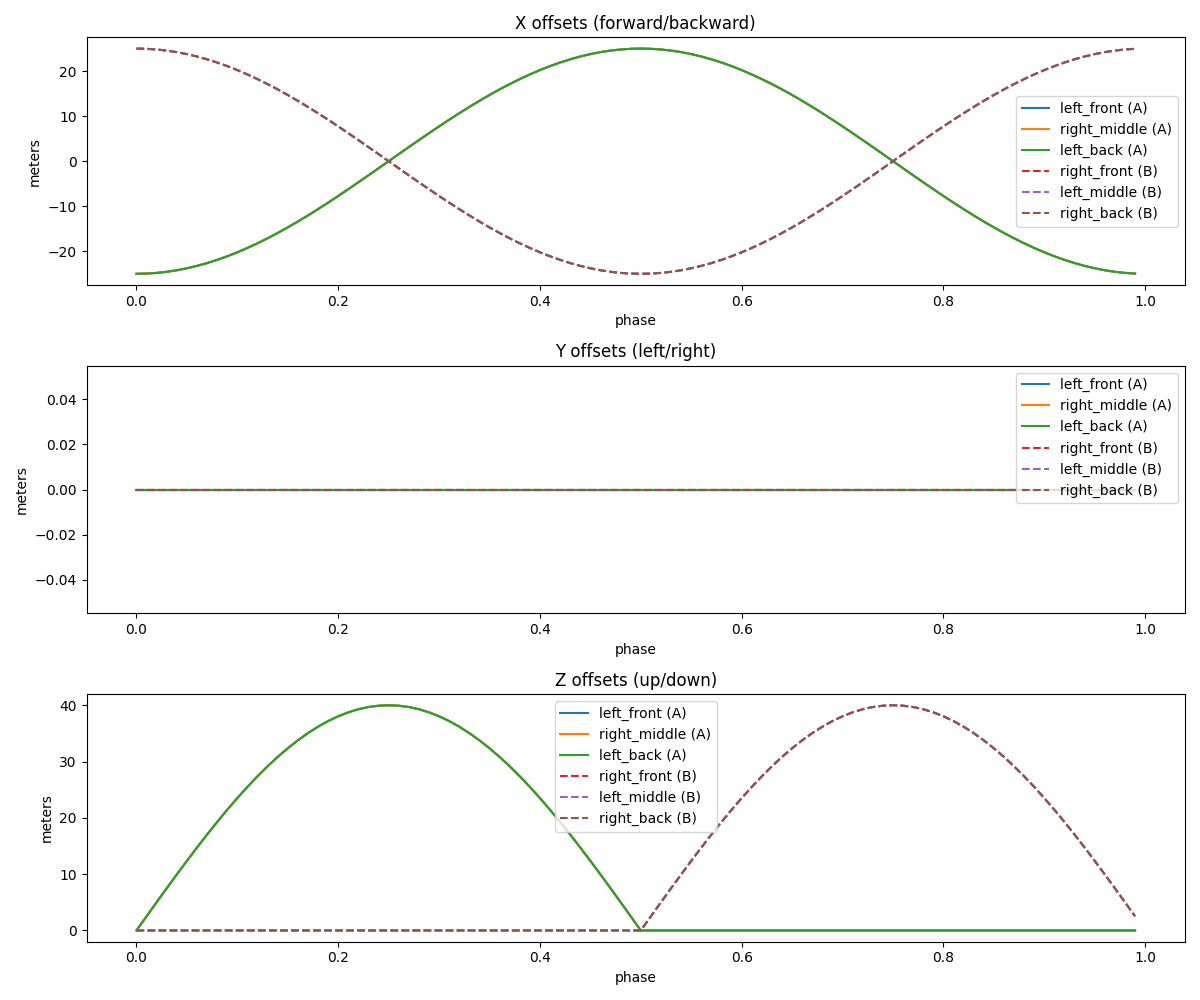

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from point import Point3D


class TripodGaitGenerator:
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Tripod gait generator for hexapod robot.

        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters

        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        # Define leg groups for tripod gait
        self.tripod_a = ['left_front', 'right_middle', 'left_back']
        self.tripod_b = ['right_front', 'left_middle', 'right_back']

    def get_offsets_at_phase(self, phase):
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Dictionary of leg positions with their corresponding offsets

        """
        # Generate offsets for each leg group
        offsets = {}

        # Tripod A legs
        for leg in self.tripod_a:
            offsets[leg] = self._calculate_leg_offset(phase)

        # Tripod B legs (half cycle offset)
        for leg in self.tripod_b:
            offsets[leg] = self._calculate_leg_offset(phase + 0.5)

        return offsets

    def get_offsets_at_phase_for_leg(self, leg, phase):
        """
        Get offsets for all legs at a specific phase (0.0 to 1.0).

        Parameters:
        -----------
            phase: Float between 0.0 and 1.0 representing the gait cycle progress

        Returns:
        --------
            Offset for the specified leg

        """
        # Tripod B legs (half cycle offset)
        if leg in self.tripod_b:
            phase += 0.5

        return self._calculate_leg_offset(phase)

    def _calculate_leg_offset(self, phase):
        # Ensure phase is between 0 and 1
        phase = phase % 1.0

        # Convert phase to angle (0 to 2π)
        t = phase * 2 * np.pi

        """Calculate offset for a single leg at angle t."""
        # X movement: forward during swing phase, backward during stance phase
        x_offset = -self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        z_offset = 0
        if np.sin(t) > 0:  # Only lift during swing phase
            z_offset = self.step_height * np.sin(t)

        # Y offset is always zero for straight walking
        y_offset = 0

        return Point3D([x_offset, y_offset, z_offset])

    def visualize_continuous(self, steps=100):
        """Visualize the gait sequence as a continuous function."""
        phases = np.linspace(0, 1, steps, endpoint=False)

        # Create data structures to store values for plotting
        x_values = {leg: [] for leg in self.tripod_a + self.tripod_b}
        y_values = {leg: [] for leg in self.tripod_a + self.tripod_b}
        z_values = {leg: [] for leg in self.tripod_a + self.tripod_b}

        # Generate data points
        for phase in phases:
            offsets = self.get_offsets_at_phase(phase)
            for leg, offset in offsets.items():
                x_values[leg].append(offset.x)
                y_values[leg].append(offset.y)
                z_values[leg].append(offset.z)

        # Plot the data
        fig, axs = plt.subplots(3, 1, figsize=(12, 10))

        # Plot x offsets
        for leg in self.tripod_a + self.tripod_b:
            if leg in self.tripod_a:
                axs[0].plot(phases, x_values[leg], label=f'{leg} (A)', linestyle='-')
            else:
                axs[0].plot(phases, x_values[leg], label=f'{leg} (B)', linestyle='--')
        axs[0].set_title('X offsets (forward/backward)')
        axs[0].set_ylabel('meters')
        axs[0].set_xlabel('phase')
        axs[0].legend()

        # Plot y offsets
        for leg in self.tripod_a + self.tripod_b:
            if leg in self.tripod_a:
                axs[1].plot(phases, y_values[leg], label=f'{leg} (A)', linestyle='-')
            else:
                axs[1].plot(phases, y_values[leg], label=f'{leg} (B)', linestyle='--')
        axs[1].set_title('Y offsets (left/right)')
        axs[1].set_ylabel('meters')
        axs[1].set_xlabel('phase')
        axs[1].legend()

        # Plot z offsets
        for leg in self.tripod_a + self.tripod_b:
            if leg in self.tripod_a:
                axs[2].plot(phases, z_values[leg], label=f'{leg} (A)', linestyle='-')
            else:
                axs[2].plot(phases, z_values[leg], label=f'{leg} (B)', linestyle='--')
        axs[2].set_title('Z offsets (up/down)')
        axs[2].set_ylabel('meters')
        axs[2].set_xlabel('phase')
        axs[2].legend()

        plt.tight_layout()
        plt.show()


# Example usage
generator = TripodGaitGenerator()

# Visualize the continuous gait
generator.visualize_continuous()


This tripod gait generator:

 1. Creates sequences for all 6 legs divided into two tripod groups
 2. Generates coordinated movement patterns where:
    - Tripod A (leftFront, rightMiddle, leftBack) moves in the first half of the cycle
    - Tripod B (rightFront, leftMiddle, rightBack) moves in the second half
    - When one tripod is lifting and moving forward, the other is on the ground providing support
 3. Provides visualization to help understand the gait pattern
 4. Allows you to extract the pose at any step in the sequence
 
The implementation is based on your existing code structure but simplified for clarity. You can adjust parameters like hipSwing, liftSwing, and stepCount to modify the gait characteristics.



In [14]:
from matplotlib.animation import FuncAnimation
from models import HexapodModel
from plotting import plot_hexapod, update_hexapod_plot

%matplotlib widget

plt.rcParams["animation.html"] = "jshtml"

skip = False
interactive = False
was_interactive = plt.isinteractive()

if interactive:
  plt.ion()
else:
  plt.ioff()

try:
  if skip:
    raise KeyboardInterrupt

  hexapod = HexapodModel()

  generator = TripodGaitGenerator(step_length=120)

  hexapod.forward_kinematics(0, -25, 110)
  leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

  total_steps = 100
  def set_pose(step):
      phase = step / total_steps
      for leg, leg_tip in zip(hexapod.legs, leg_tips):
          offsets = generator.get_offsets_at_phase_for_leg(leg.label, phase)
          leg.move_to(leg_tip + offsets)

  fig, ax, plot_data = plot_hexapod(hexapod)
  ax.view_init(elev=7.0, azim=-112)

  def animate(frame):
      set_pose(frame)
      update_hexapod_plot(hexapod, plot_data)

  anim = FuncAnimation(fig, animate, frames=total_steps, interval=20)

  if not skip:
    # see plt.ion() / plt.ioff() at the top of this cell
    if not plt.isinteractive():
        display(anim)
except KeyboardInterrupt:
  print("Skipping animation")
finally:
  if was_interactive:
    plt.ion()
  else:
    plt.ioff()